In [ ]:
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q pydub librosa transformers scikit-learn fastapi uvicorn gradio


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.8 MB/s eta

In [ ]:
import os
import whisper
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pydub import AudioSegment
from IPython.display import Audio, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

AUDIO_DIR = "/content/drive/MyDrive/audio_samples"
audio_files = [os.path.join(AUDIO_DIR, f) for f in os.listdir(AUDIO_DIR) if f.endswith(".wav")]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. TRANSCRIPTION (Whisper)
# =======================
import warnings
warnings.filterwarnings("ignore", message="FP16 is not supported on CPU; using FP32 instead")

model = whisper.load_model("base")  # Can use "small" or "medium" for better accuracy

transcripts = {}

for file in audio_files:
    print(f"Transcribing {file}...")
    result = model.transcribe(file)
    transcripts[file] = result['text']
    print(result['text'])


Transcribing /content/drive/MyDrive/audio_samples/harvard.wav...
 The stale smell of old beer lingers. It takes heat to bring out the odor. A cold dip restores health and zest. A salt pickle tastes fine with ham. Tacos al pastor are my favorite. A zestful food is the hot cross bun.
Transcribing /content/drive/MyDrive/audio_samples/genevieve.wav...
 This dynamic workshop aims to provide up to date information on pharmacological approaches, comma, issues, comma, and treatment in the geriatric population to assist in preventing medication-related problems, comma, appropriately and effectively managing medications and compliance period. The concept of polypharmacy, parentheses, taking multiple types of drugs, parentheses, will also be discussed, comma, as this is a common issue that can impact adverse side effects in the geriatric population period. Participants will leave with the knowledge and considerations of common drug interaction and how to minimize effects that limit function. Peri

In [ ]:
#  3. AUDIO FEATURES EXTRACTION
# =======================

def extract_audio_features(file):
    y, sr = librosa.load(file)

    # Duration
    duration = librosa.get_duration(y=y, sr=sr)

    # Pitch features
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = pitches[magnitudes > np.median(magnitudes)]
    pitch_mean = np.mean(pitch)
    pitch_std = np.std(pitch)

    # Speech rate estimation (words/sec)
    transcript = transcripts[file]
    num_words = len(transcript.split())
    speech_rate = num_words / duration

    # Silence detection using energy threshold
    intervals = librosa.effects.split(y, top_db=30)
    silence_durations = []
    for i in range(1, len(intervals)):
        prev_end = intervals[i-1][1]
        curr_start = intervals[i][0]
        silence_durations.append((curr_start - prev_end) / sr)

    avg_pause = np.mean(silence_durations) if silence_durations else 0
    pause_count = len(silence_durations)

    # Hesitation markers
    hesitations = transcript.lower().count("uh") + transcript.lower().count("um")

    return {
        "filename": os.path.basename(file),
        "duration_sec": duration,
        "speech_rate": speech_rate,
        "avg_pause": avg_pause,
        "pause_count": pause_count,
        "pitch_mean": pitch_mean,
        "pitch_std": pitch_std,
        "hesitations": hesitations,
    }

feature_list = [extract_audio_features(file) for file in audio_files]
feature_df = pd.DataFrame(feature_list)


In [ ]:
# 4. UNSUPERVISED MODELING
# =======================

X = feature_df.drop(columns=['filename'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = IsolationForest(contamination=0.3)
feature_df['anomaly_score'] = model.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
feature_df['pca_x'] = X_pca[:, 0]
feature_df['pca_y'] = X_pca[:, 1]

In [ ]:
print(feature_df)


                filename  duration_sec  speech_rate  avg_pause  pause_count  \
0            harvard.wav     18.356190     2.342534   0.193500           21   
1          genevieve.wav     70.334558     1.777220   0.191332           50   
2  winston-churchill.wav    295.056009     1.999620   0.463556          248   

    pitch_mean    pitch_std  hesitations  anomaly_score     pca_x     pca_y  
0  1532.100220  1147.677856            0              1 -2.274300  1.414326  
1  1326.209961  1079.390259            1              1 -0.711472 -2.012163  
2  1657.135864   996.790100            1             -1  2.985772  0.597837  


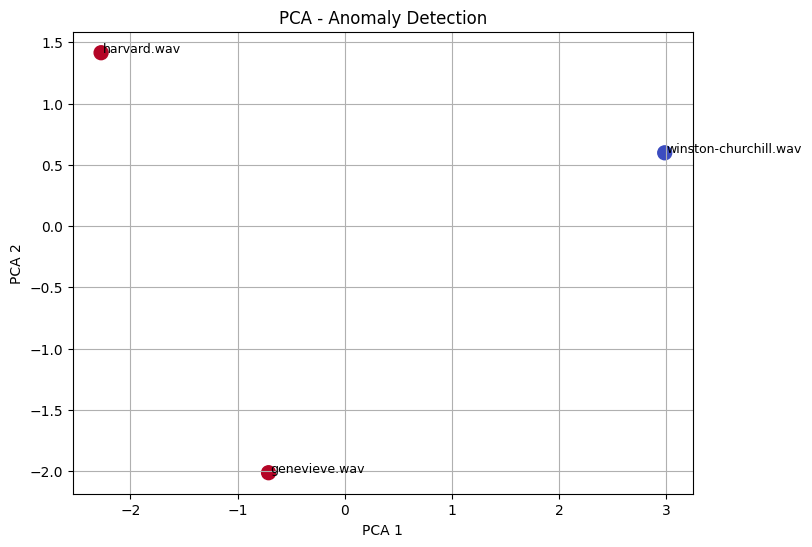

In [ ]:
# 5. VISUALIZATION
# =======================

plt.figure(figsize=(8,6))
plt.title("PCA - Anomaly Detection")
plt.scatter(feature_df['pca_x'], feature_df['pca_y'], c=feature_df['anomaly_score'], cmap='coolwarm', s=100)
for i, row in feature_df.iterrows():
    plt.text(row['pca_x']+0.02, row['pca_y'], row['filename'], fontsize=9)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid()
plt.show()


In [ ]:
#  6. REPORT (Markdown Style)
# =======================

from IPython.display import Markdown

Markdown("""
### 🔍 Report Summary

**Most Insightful Features:**
- Average pause duration and count (indicator of hesitation or memory retrieval effort)
- Hesitation marker count ("uh", "um")
- Pitch variability (higher std indicates anxiety or uncertainty)

**Model Used:**
- Isolation Forest (Unsupervised Anomaly Detection)
- PCA used for visualization

**Next Steps:**
- Use real patient data with ground truth
- Enhance STT with better diarization
- Use transformer-based text understanding for deeper analysis

---
""")



### 🔍 Report Summary

**Most Insightful Features:**
- Average pause duration and count (indicator of hesitation or memory retrieval effort)
- Hesitation marker count ("uh", "um")
- Pitch variability (higher std indicates anxiety or uncertainty)

**Model Used:**
- Isolation Forest (Unsupervised Anomaly Detection)
- PCA used for visualization

**Next Steps:**
- Use real patient data with ground truth
- Enhance STT with better diarization
- Use transformer-based text understanding for deeper analysis

---


In [ ]:
# Voice Analysis FastAPI Endpoint (main.py)

from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
from pydantic import BaseModel
import uvicorn
import whisper
import librosa
import numpy as np
import tempfile
import os

app = FastAPI(title="Cognitive Voice Analysis API")

# Load Whisper model
whisper_model = whisper.load_model("base")

# Feature extraction logic
def analyze_audio(file_path, transcript):
    y, sr = librosa.load(file_path)
    duration = librosa.get_duration(y=y, sr=sr)

    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = pitches[magnitudes > np.median(magnitudes)]
    pitch_mean = float(np.mean(pitch)) if len(pitch) > 0 else 0
    pitch_std = float(np.std(pitch)) if len(pitch) > 0 else 0

    num_words = len(transcript.split())
    speech_rate = float(num_words / duration)

    intervals = librosa.effects.split(y, top_db=30)
    silence_durations = []
    for i in range(1, len(intervals)):
        prev_end = intervals[i-1][1]
        curr_start = intervals[i][0]
        silence_durations.append((curr_start - prev_end) / sr)

    avg_pause = float(np.mean(silence_durations)) if silence_durations else 0
    pause_count = len(silence_durations)
    hesitations = transcript.lower().count("uh") + transcript.lower().count("um")

    return {
        "duration_sec": duration,
        "speech_rate": speech_rate,
        "avg_pause": avg_pause,
        "pause_count": pause_count,
        "pitch_mean": pitch_mean,
        "pitch_std": pitch_std,
        "hesitations": hesitations,
        "transcript": transcript
    }

@app.post("/analyze")
async def analyze(file: UploadFile = File(...)):
    try:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
            tmp.write(await file.read())
            tmp_path = tmp.name

        result = whisper_model.transcribe(tmp_path)
        transcript = result["text"]
        features = analyze_audio(tmp_path, transcript)

        os.unlink(tmp_path)
        return JSONResponse(content={"filename": file.filename, "features": features})

    except Exception as e:
        return JSONResponse(status_code=500, content={"error": str(e)})

if __name__ == "__main__":
    uvicorn.run("main:app", host="0.0.0.0", port=8000, reload=True)

INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [608] using StatReload
INFO:     Stopping reloader process [608]
